# Animal Breed Classification 
## Using Image Generator to load data

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input, Flatten
from keras.optimizers import Adam
from sklearn.utils import shuffle
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

In [53]:
nameToNum={}
numToName={}
x= [] #np.array([])
y=[]
imgShape=(150,150,3)
dirName=r"animal_breed_classification_ai_challenge-dataset/TRAIN/"

In [167]:
datagen = ImageDataGenerator(rescale= 1./255,
                             zoom_range = 0.2,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             #rotation_range = 30,
                             horizontal_flip=True,
                             brightness_range=[0.8, 1.2],
                             fill_mode='nearest')


'''datagen = ImageDataGenerator(rescale= 1./255,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)'''

xtrain = datagen.flow_from_directory(
    directory = dirName,
    target_size = imgShape[:2],
    batch_size = 64,
    class_mode = "categorical", shuffle=True
)

Found 5890 images belonging to 37 classes.


In [147]:
def printResults(history):
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.legend(["Acc"])
    plt.show()
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.legend(["Loss"])
    plt.show()
    plt.plot(history.history['F1_Score'])
    #plt.plot(history.history['val_F1_Score'])
    plt.legend(["F1"])
    plt.show()


In [98]:
from keras import backend as K

def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [142]:
def makeModel():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(4,4), padding='Same',activation = 'relu', input_shape=imgShape))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(128,kernel_size=(3,3),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(256,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(512,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    model.add(Conv2D(1024,kernel_size=(2,2),padding='Same',activation = 'relu'))
    model.add(MaxPool2D(2,2))
    
    
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(37,activation='softmax'))
    
    print(model.summary())
    
    return model

In [143]:
model = makeModel()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_218 (Conv2D)          (None, 150, 150, 64)      3136      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 75, 75, 128)       73856     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 37, 37, 256)       131328    
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 18, 18, 256)       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 18, 18, 512)      

In [144]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',F1_Score])

In [145]:
history = model.fit(xtrain,verbose=1,epochs=10)

Epoch 1/10
185/185 [==============================] - 52s 275ms/step - loss: 3.6130 - accuracy: 0.0239 - F1_Score: 0.0000e+00
Epoch 2/10
171/185 [==========================>...] - ETA: 3s - loss: 3.6115 - accuracy: 0.0244 - F1_Score: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
printResults(history)

# Pre-Trained:

In [103]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [148]:
baseModel = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3), pooling='avg')

In [150]:
#picsTrain = preprocess_input(xtrain)
#picsTrain

In [168]:
x = baseModel.output
x = Dense(1024, name='classifier1', activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, name='classifier2', activation='relu')(x)
x = Dropout(0.2)(x)
xout = Dense(37, name='output', activation='softmax')(x)

# create a model whose input is input of the base model and output is x_out
model = Model(baseModel.input, xout)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_223 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_223[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [169]:
# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy',F1_Score])

In [170]:
history = model.fit(xtrain, epochs=20,batch_size=64)

Epoch 1/20
93/93 [==============================] - 56s 536ms/step - loss: 1.7247 - accuracy: 0.5365 - F1_Score: 0.5253
Epoch 2/20
93/93 [==============================] - 50s 540ms/step - loss: 1.0998 - accuracy: 0.6779 - F1_Score: 0.6905
Epoch 3/20
93/93 [==============================] - 50s 534ms/step - loss: 0.9750 - accuracy: 0.7073 - F1_Score: 0.7146
Epoch 4/20
93/93 [==============================] - 50s 542ms/step - loss: 0.9856 - accuracy: 0.7078 - F1_Score: 0.7154
Epoch 5/20
93/93 [==============================] - 50s 536ms/step - loss: 0.9026 - accuracy: 0.7302 - F1_Score: 0.7292
Epoch 6/20
93/93 [==============================] - 50s 536ms/step - loss: 0.9336 - accuracy: 0.7165 - F1_Score: 0.7193
Epoch 7/20
93/93 [==============================] - 50s 537ms/step - loss: 0.8269 - accuracy: 0.7458 - F1_Score: 0.7536
Epoch 8/20
93/93 [==============================] - 50s 537ms/step - loss: 0.7772 - accuracy: 0.7587 - F1_Score: 0.7639
Epoch 9/20
93/93 [======================

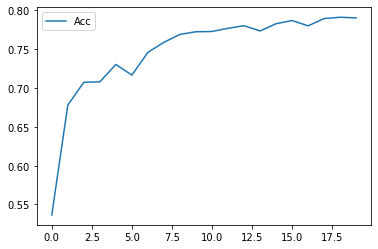

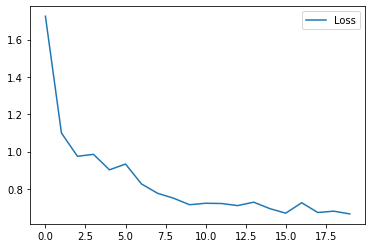

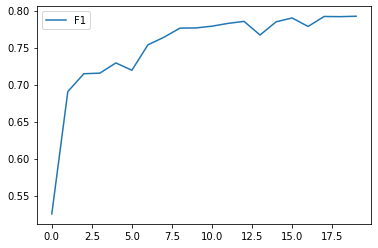

In [171]:
printResults(history)

# Load exam and test:

In [172]:
exam= [] #np.array([])
imgShape=(150,150,3)
dirNameTest=r"animal_breed_classification_ai_challenge-dataset/TEST/"

In [173]:
fname, test = [], []
from glob import glob
for infile in glob(dirNameTest + "/*.jpg"):
  img = Image.open(infile)
  img = img.resize((150,150))
  fname.append(infile.split('\\')[-1])
  img_arr = np.asarray(img)
  test.append(img_arr.reshape(150,150, 3))

test_len = len(test)
test = np.array(test)

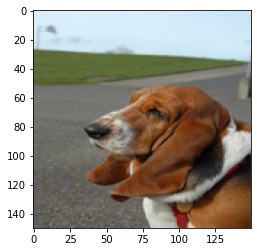

In [174]:
plt.imshow(test[1000])

In [175]:
MAPPER = {v: k for k, v in xtrain.class_indices.items()}

In [176]:
test_len

1500

In [177]:
test.shape

(1500, 150, 150, 3)

In [178]:
test = test / 255.
    
y_test_pred = np.argmax(model.predict(test), axis=1).tolist()
y_test_pred = [MAPPER[val] for val in y_test_pred]

In [179]:
import pandas as pd

submit = pd.DataFrame({'Filename': fname, 'Class': y_test_pred})

In [180]:
submit

,Filename,Class
0,1.jpg,staffordshire_bull_terrier
1,10.jpg,pug
2,100.jpg,chihuahua
3,1000.jpg,miniature_pinscher
4,1001.jpg,pomeranian
...,...,...
1495,995.jpg,russian_blue
1496,996.jpg,british_shorthair
1497,997.jpg,american_pit_bull_terrier
1498,998.jpg,staffordshire_bull_terrier


In [181]:
submit.to_csv('Attempt 7.csv', index=False)